In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from pathlib import Path

### Load data

In [15]:
TRADING_DAYS_IN_YEAR = 252

In [38]:
day_close_folder = Path('../data/day_close/')
assert day_close_folder.exists()
tickers = [file.removesuffix('.csv') for file in os.listdir(day_close_folder)]
print(len(tickers))

dfs = {ticker: pd.read_csv(day_close_folder / f'{ticker}.csv', parse_dates=['TRADEDATE']).dropna() for ticker in tickers}
assert len(dfs) == len(tickers)
for df in dfs.values():
    assert np.all(next(iter(dfs.values())).columns == df.columns)
    assert len(df['TRADEDATE']) == len(df['TRADEDATE'].drop_duplicates())
    assert np.all(df['TRADEDATE'].sort_values() == df['TRADEDATE'])
    assert np.all(df['BOARDID'] == 'TQBR')

244


### Filter top N stocks with the earliest start date

In [18]:
def get_is_eligible(df: pd.DataFrame, date: datetime.date) -> bool:
    return df.iloc[0]['TRADEDATE'] <= pd.to_datetime(date)  # noqa


def filter_dfs(dfs: dict[str, pd.DataFrame], n_target_stocks: int, remove_tickers: list[str]) -> dict[str, pd.DataFrame]:
    day = datetime.timedelta(days=1)
    left = datetime.date(2000, 1, 1)
    right = datetime.date.today()
    filtered_tickers = list(dfs.keys())
    # (left, right]
    while left + day != right:
        middle = left + (right - left) // 2
        is_eligible = [get_is_eligible(dfs[ticker], middle) for ticker in filtered_tickers]
        if sum(is_eligible) >= n_target_stocks:
            filtered_tickers = [ticker for i, ticker in enumerate(filtered_tickers) if is_eligible[i]]
            right = middle
        else:
            left = middle
    if len(filtered_tickers) != n_target_stocks:
        assert sum([get_is_eligible(dfs[ticker], left) for ticker in filtered_tickers]) < n_target_stocks
        assert sum([get_is_eligible(dfs[ticker], right) for ticker in filtered_tickers]) >= n_target_stocks
        assert remove_tickers
    print(f'Drop tickers: {[ticker for ticker in filtered_tickers if ticker in remove_tickers]}')
    filtered_tickers = [ticker for ticker in filtered_tickers if ticker not in remove_tickers]
    assert len(filtered_tickers) == n_target_stocks or len(filtered_tickers) == n_target_stocks - len(remove_tickers)
    return {ticker: dfs[ticker].copy() for ticker in filtered_tickers}


N_TARGET_STOCKS = 31
REMOVE_TICKERS = ['IRAO']

# N_TARGET_STOCKS = 5
# REMOVE_TICKERS = ['HYDR']

dfs = filter_dfs(dfs, n_target_stocks=N_TARGET_STOCKS, remove_tickers=REMOVE_TICKERS)
print(f'Number of stocks after filtering: {len(dfs)}')
print(f'Stocks: {list(dfs.keys())}')

Drop tickers: ['IRAO']
Number of stocks after filtering: 30
Stocks: ['AFLT', 'ALRS', 'GCHE', 'HYDR', 'LKOH', 'LSRG', 'MGNT', 'MOEX', 'MRKC', 'MRKP', 'MSNG', 'MSRS', 'MTLR', 'MTLRP', 'MTSS', 'NVTK', 'PHOR', 'PIKK', 'POLY', 'RTKM', 'RTKMP', 'SBER', 'SBERP', 'TATN', 'TATNP', 'TGKA', 'TRMK', 'TRNFP', 'UTAR', 'VTBR']


From 2013-12-16 to 2023-03-28


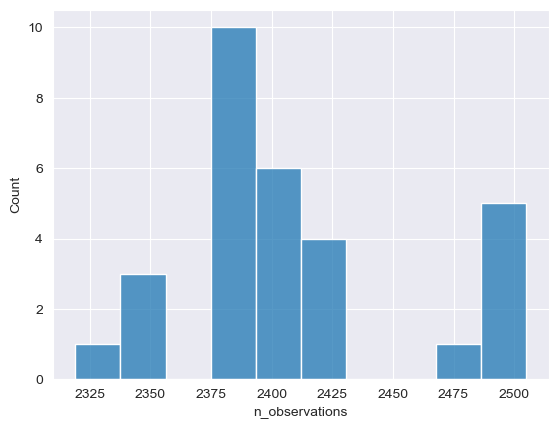

In [19]:
start_date = max(map(lambda df: df.iloc[0]['TRADEDATE'], dfs.values()))
finish_date = min(map(lambda df: df.iloc[-1]['TRADEDATE'], dfs.values()))
print(f'From {start_date.strftime("%Y-%m-%d")} to {finish_date.strftime("%Y-%m-%d")}')
sns.histplot([df.shape[0] for df in dfs.values()])
plt.xlabel('n_observations')
plt.show()

### Merge DataFrames

In [20]:
def merge_dfs(dfs: dict[str, pd.DataFrame], date_column, price_column: str):
    result_df = None
    for ticker, df in dfs.items():
        df = df.copy().set_index(date_column)
        if result_df is None:
            result_df = df[[price_column]]
            result_df.columns = [ticker]
        else:
            result_df = result_df.join(df[[price_column]].rename(columns={'CLOSE': ticker}))
    return result_df


df_price = merge_dfs(dfs, date_column='TRADEDATE', price_column='CLOSE').dropna()
assert len(df_price.columns) == len(dfs)
print(f'DataFrame size after merge: {len(df_price)}')

DataFrame size after merge: 2226


### Train test split

In [21]:
TEST_RATIO = 0.3
test_size = round(len(df_price) * TEST_RATIO)
train_size = len(df_price) - test_size
df_price_train = df_price.iloc[:-test_size]
df_price_test = df_price.iloc[-test_size:]
# assert len(df_price_train) == train_size and len(df_price_test) == test_size
assert len(set(df_price_test.index) & set(df_price_train.index)) == 0

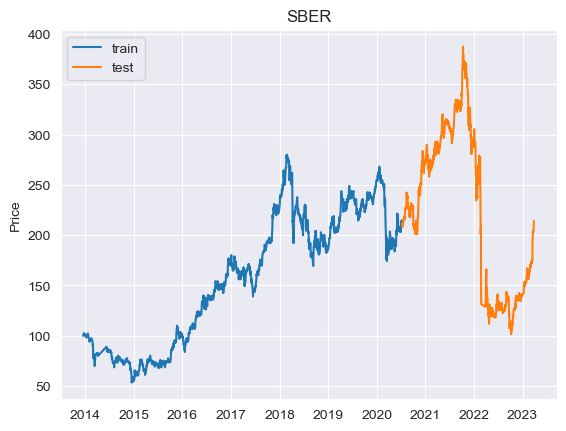

In [22]:
ticker = 'SBER'
plt.plot(df_price_train[ticker], label='train')
plt.plot(df_price_test[ticker], label='test')
plt.ylabel('Price')
plt.title(ticker)
plt.legend(loc='upper left')
plt.show()

### Return and correlation/covariance matrix calculation

In [23]:
def get_returns_cov_corr(df_price) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_returns = df_price.pct_change().dropna()  # p(t) / p(t - 1) - 1
    matrix_corr = df_returns.corr()
    matrix_cov = df_returns.cov()
    assert matrix_corr.shape == matrix_cov.shape == (df_returns.shape[1], df_returns.shape[1])
    return df_returns, matrix_cov, matrix_corr

In [24]:
df_returns_train, matrix_cov_train, matrix_corr_train = get_returns_cov_corr(df_price_train)

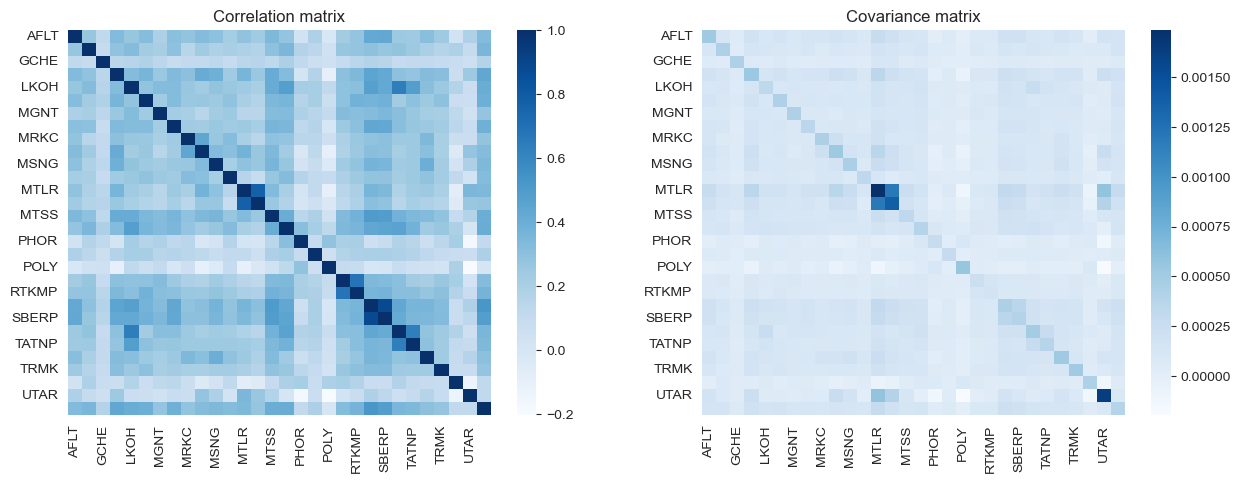

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
for matrix, title, ax in [(matrix_corr_train, 'Correlation', ax1), (matrix_cov_train, 'Covariance', ax2)]:
    sns.heatmap(matrix, cmap='Blues', ax=ax)
    ax.set_title(f'{title} matrix')
plt.show()

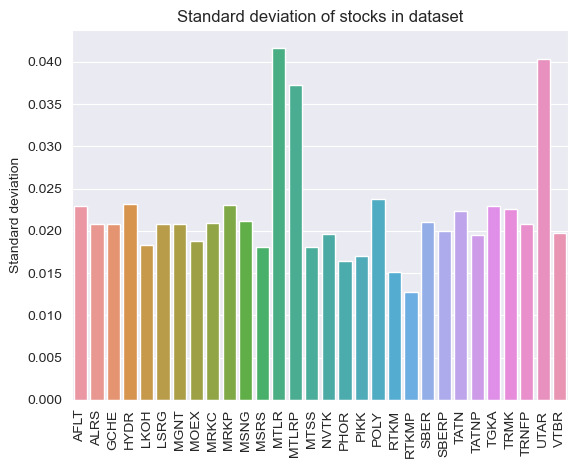

In [26]:
sns.barplot(x=matrix_cov_train.index, y=np.sqrt(np.diagonal(matrix_cov_train.values)))
plt.title('Standard deviation of stocks in dataset')
plt.ylabel('Standard deviation')
plt.xticks(rotation=90)
plt.show()

### Markowitz portfolio optimization

In [27]:
def markowitz(df_price: pd.DataFrame, mu: float) -> pd.Series:
    n_assets = len(df_price.columns)
    df_returns, matrix_cov, matrix_corr = get_returns_cov_corr(df_price_train)
    returns = df_returns.values.mean(axis=0).reshape(-1, 1)
    sigma = matrix_cov.values
    ones = np.ones((n_assets, 1))
    zeros = np.zeros((1, 1))
    X = np.block([[2 * sigma, -returns, -ones],
                  [returns.T, zeros, zeros],
                  [ones.T, zeros, zeros]])
    assert X.shape[0] == X.shape[1]
    assert X.shape[0] == n_assets + 2
    b = np.array([0.0] * n_assets + [mu, 1.0]).reshape(-1, 1)
    assert X.shape[0] == b.shape[0]
    x = np.linalg.solve(X, b).reshape(-1)
    assert x.shape[0] == n_assets + 2
    w = x[:n_assets]
    lambda_1 = x[n_assets]
    lambda_2 = x[n_assets + 1]
    w = pd.Series(w, df_price.columns)
    assert np.isclose(w.sum(), 1.0)
    return w


def plot_weights(w: pd.Series):
    sns.barplot(x=w.index, y=w)
    plt.ylabel('Weight')
    plt.xticks(rotation=90)

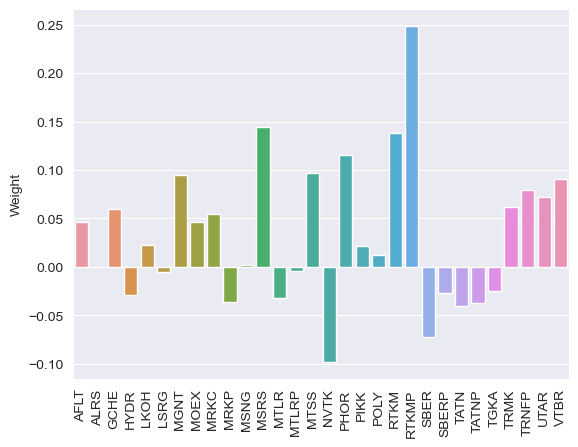

In [28]:
w_markowitz_train = markowitz(df_price_train, 0.0)
assert len(w_markowitz_train.shape) == 1
w_equal = w_markowitz_train.copy()
w_equal = pd.Series(np.full_like(w_equal, fill_value=1 / w_equal.shape[0]), w_equal.index)
plot_weights(w_markowitz_train)

### Comparison between Markowitz and Equal strategies

In [29]:
def get_portfolio_returns(df_price: pd.DataFrame, w: pd.Series, label: str) -> pd.Series:
    n_assets = len(df_price.columns)
    df_returns, matrix_cov, matrix_corr = get_returns_cov_corr(df_price)
    assert df_returns.shape[1] == n_assets
    assert np.all(w.index == df_price.columns)
    # at t we decide to allocate w rubles to each asset
    # then we get the return p(t + 1) / p(t) - 1
    portfolio_returns = df_returns @ w  # df_return is p(t) / p(t - 1) - 1
    portfolio_returns_pct = portfolio_returns * 100
    print(f'{label} portfolio returns: '
          f'{portfolio_returns_pct.mean() * TRADING_DAYS_IN_YEAR:.10f}% ± '
          f'{portfolio_returns_pct.std() * np.sqrt(TRADING_DAYS_IN_YEAR):.3f}%')
    return portfolio_returns


def plot_portfolio_value(portfolio_returns: pd.Series, start_point: float, label: str):
    # Plot portfolio value
    cumulative_returns = start_point + np.cumsum(portfolio_returns)
    plt.plot(cumulative_returns * 100, label=label)
    plt.title('Portfolio value')
    plt.ylabel('Change, %')


def plot_portfolio_returns_hist(portfolio_returns: pd.Series, label: str):
    # Plot portfolio returns histogram
    plt.gcf().set_figwidth(11)
    sns.histplot(portfolio_returns * 100, stat='density', label=label, legend=False, alpha=0.7)
    plt.xlabel('Return, %')


def plot_portfolio_returns_train_test(portfolio_returns_train: pd.Series, portfolio_returns_test: pd.Series, label: str):
    plot_portfolio_returns_hist(
        portfolio_returns_train.clip(
            lower=portfolio_returns_train.quantile(0.01),
            upper=portfolio_returns_train.quantile(0.99)
        ),
        label=f'Train {label}'
    )

    plot_portfolio_returns_hist(
        portfolio_returns_test.clip(
            lower=portfolio_returns_test.quantile(0.01),
            upper=portfolio_returns_test.quantile(0.99)
        ),
        label=f'Test {label}'
    )

In [30]:
portfolio_returns_markowitz_train = get_portfolio_returns(df_price_train, w_markowitz_train, 'Train Markowitz')
portfolio_returns_equal_train = get_portfolio_returns(df_price_train, w_equal, 'Train Equal')
print()
portfolio_returns_markowitz_test = get_portfolio_returns(df_price_test, w_markowitz_train, 'Test Markowitz')
portfolio_returns_equal_test = get_portfolio_returns(df_price_test, w_equal, 'Test Equal')

Train Markowitz portfolio returns: -0.0000000000% ± 15.290%
Train Equal portfolio returns: 14.3626120418% ± 17.486%

Test Markowitz portfolio returns: 2.7399261011% ± 22.234%
Test Equal portfolio returns: 8.1709641956% ± 27.609%


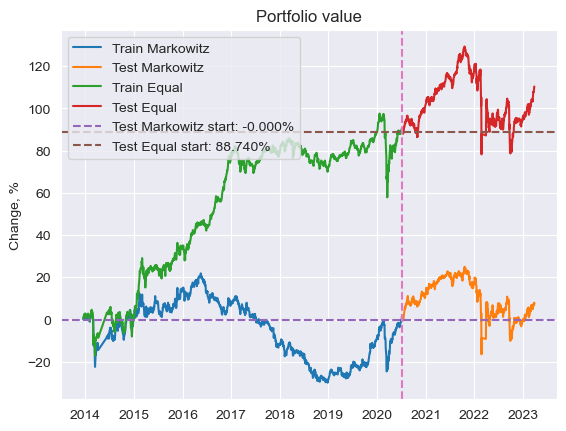

In [31]:
plot_portfolio_value(portfolio_returns_markowitz_train, 0.0, 'Train Markowitz')
start_point_markowitz_test = portfolio_returns_markowitz_train.sum()
plot_portfolio_value(portfolio_returns_markowitz_test, start_point_markowitz_test, 'Test Markowitz')

plot_portfolio_value(portfolio_returns_equal_train, 0.0, 'Train Equal')
start_point_equal_test = portfolio_returns_equal_train.sum()
plot_portfolio_value(portfolio_returns_equal_test, start_point_equal_test, 'Test Equal')

plt.axhline(start_point_markowitz_test * 100, color='C4', label=f'Test Markowitz start: {start_point_markowitz_test * 100:.3f}%', linestyle='dashed')
plt.axhline(start_point_equal_test * 100, color='C5', label=f'Test Equal start: {start_point_equal_test * 100:.3f}%', linestyle='dashed')

plt.axvline(df_price_test.index[0], linestyle='dashed', color='C6')

plt.legend()
plt.show()

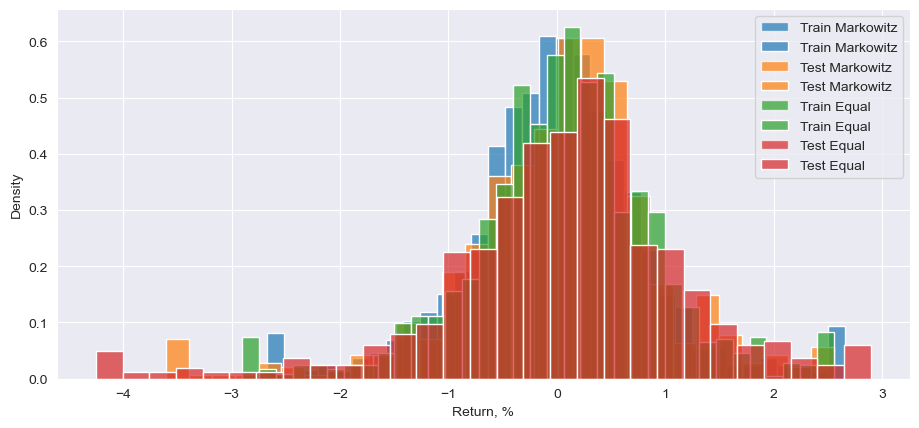

In [32]:
plot_portfolio_returns_train_test(portfolio_returns_markowitz_train, portfolio_returns_markowitz_test, label='Markowitz')
plot_portfolio_returns_train_test(portfolio_returns_equal_train, portfolio_returns_equal_test, label='Equal')
plt.legend()
plt.show()

### Markowitz with annual return mu=20%

In [33]:
mu_pct_year = 20
mu = (mu_pct_year / 100) / TRADING_DAYS_IN_YEAR  # 10% per year
w_markowitz_mu_train = markowitz(df_price_train, mu)

portfolio_returns_markowitz_mu_train = get_portfolio_returns(df_price_train, w_markowitz_mu_train, f'Train Markowitz mu={mu_pct_year}%')
portfolio_returns_equal_train = get_portfolio_returns(df_price_train, w_equal, 'Train Equal')
print()
portfolio_returns_markowitz_mu_test = get_portfolio_returns(df_price_test, w_markowitz_mu_train, f'Test Markowitz mu={mu_pct_year}%')
portfolio_returns_equal_test = get_portfolio_returns(df_price_test, w_equal, 'Test Equal')

Train Markowitz mu=20% portfolio returns: 20.0000000000% ± 13.211%
Train Equal portfolio returns: 14.3626120418% ± 17.486%

Test Markowitz mu=20% portfolio returns: 12.9061995906% ± 22.972%
Test Equal portfolio returns: 8.1709641956% ± 27.609%


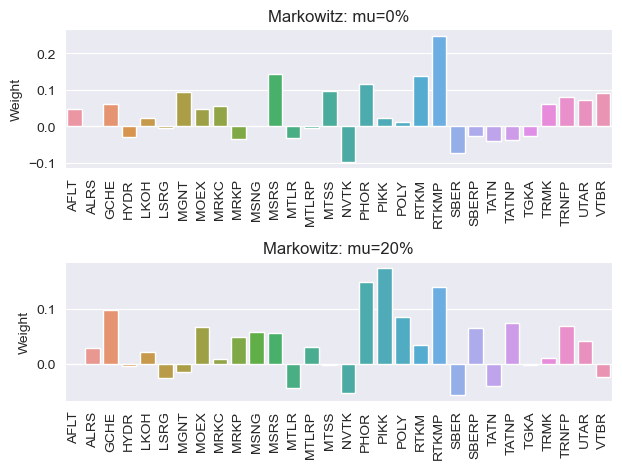

In [34]:
plt.subplots(2, 1)
plt.subplot(2, 1, 1)
plt.title('Markowitz: mu=0%')
plot_weights(w_markowitz_train)
plt.subplot(2, 1, 2)
plt.title(f'Markowitz: mu={mu_pct_year}%')
plot_weights(w_markowitz_mu_train)
plt.tight_layout()

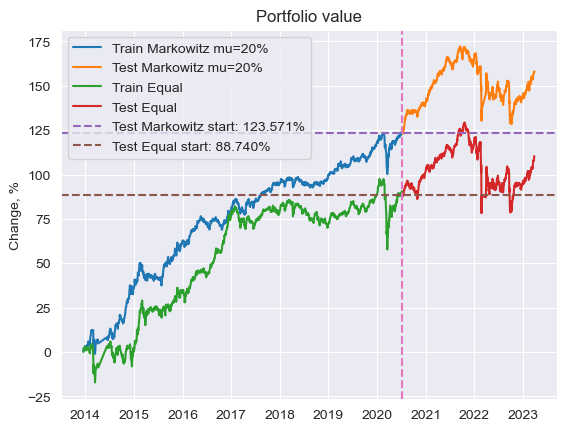

In [35]:
plot_portfolio_value(portfolio_returns_markowitz_mu_train, 0.0, f'Train Markowitz mu={mu_pct_year}%')
start_point_markowitz_mu_test = portfolio_returns_markowitz_mu_train.sum()
plot_portfolio_value(portfolio_returns_markowitz_mu_test, start_point_markowitz_mu_test, f'Test Markowitz mu={mu_pct_year}%')

plot_portfolio_value(portfolio_returns_equal_train, 0.0, 'Train Equal')
start_point_equal_test = portfolio_returns_equal_train.sum()
plot_portfolio_value(portfolio_returns_equal_test, start_point_equal_test, 'Test Equal')

plt.axhline(start_point_markowitz_mu_test * 100, color='C4', label=f'Test Markowitz start: {start_point_markowitz_mu_test * 100:.3f}%', linestyle='dashed')
plt.axhline(start_point_equal_test * 100, color='C5', label=f'Test Equal start: {start_point_equal_test * 100:.3f}%', linestyle='dashed')

plt.axvline(df_price_test.index[0], linestyle='dashed', color='C6')

plt.legend()
plt.show()

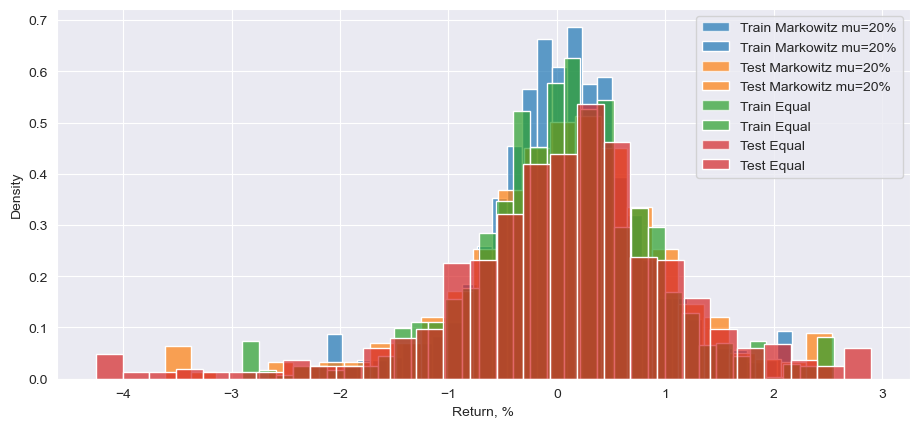

In [36]:
plot_portfolio_returns_train_test(portfolio_returns_markowitz_mu_train, portfolio_returns_markowitz_mu_test, label=f'Markowitz mu={mu_pct_year}%')
plot_portfolio_returns_train_test(portfolio_returns_equal_train, portfolio_returns_equal_test, label='Equal')
plt.legend()
plt.show()